In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import channel_model

from mpl_toolkits.mplot3d import Axes3D # added this for part C
from matplotlib import cm

# Part a: Write a script that generates one full codeword from a 10-bit LFSR and confirms it is an MLS. 
* Initialize all your LFSR bits to be 1. 
* Apply BPSK modulation to the code to map the chips from {0, 1} to {±1}. 
    (This modulates the phase of the signal)
* Develop a cyclic autocorrelation function (numpy.correlate does not suffice because it does frequency correlation)
* Plot one period of the cyclic autocorrelation of your BPSK modulated codeword to confirm that it is in fact an m-sequence 
* Result: perfect spike at n = 0 and no noise around it


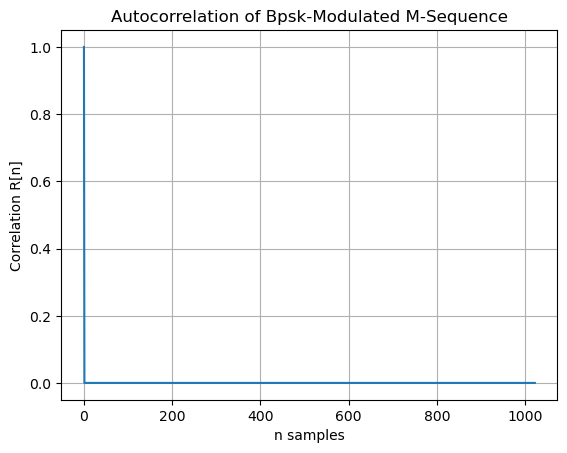

First 20 chips of the codeword: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
First 20 chips of bpsk codeword: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1]
Length of the codeword: 1023
Length of the correlation array: (1023,)


In [40]:
def tenbit_lfsr():
    """
    Generates a 10-bit LFSR m-sequence of length 1023 using taps at bits 3 and 10.
    """
    mls_codeword = []
    a = [1] * 10
    chip = 0
    while chip < 1023:
        mls_codeword.append(a[0])
        left_bit = a[0] ^ a[3]
        a = a[1:] + [left_bit]
        chip += 1
    return mls_codeword

def bpsk(codeword):
    """
    Applies BPSK modulation to a binary codeword:
    - Maps 0 → +1
    - Maps 1 → -1
    """
    codeword = np.array(codeword)
    return np.where(codeword == 0, 1, -1)
    

def cyclic_autocorrelate(codeword_one, codeword_two, N):
    """
    Return an array of length N where each element holds the normalized dot product of the 
    time-delayed signal and the original signal
    """
    corr_array = [0]*N
    for n in range(N):
        corr_array[n] = np.abs((np.sum(codeword_one * (np.roll(codeword_two,-n))))/N)
    return corr_array


mls_codeword = tenbit_lfsr()
bpsk_codeword = bpsk(mls_codeword)
N = len(bpsk_codeword)

corr_array = cyclic_autocorrelate(bpsk_codeword,bpsk_codeword, N) # Compute autocorrelation

plt.plot(corr_array)
plt.grid()
plt.title('Autocorrelation of Bpsk-Modulated M-Sequence')
plt.xlabel('n samples')
plt.ylabel('Correlation R[n]')
plt.show()


print("First 20 chips of the codeword:", mls_codeword[:20])
print("First 20 chips of bpsk codeword:", bpsk_codeword[:20])
print("Length of the codeword:", N)
print("Length of the correlation array:", np.shape(corr_array)) #correlation array should be 2*N, where N is length of codeword

# Part b: Correlation Between Static Channel Codeword and Ideal Codeword
1. upsample from 1 to 3 samples per chip of the codeword
2. pass codeword through static channel model
3. plot one period of the correlation between the channel output signal and your ideal codeword
4. calculate the TOF delay ˆτ and the pseudorange ˆρ of the static channel from the correlation



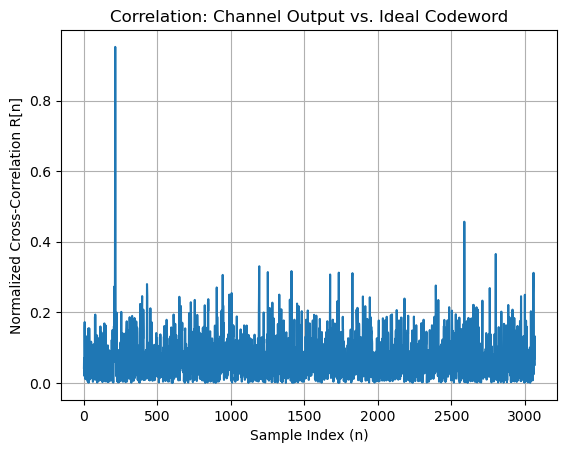

TOF Delay:  6.940371456500489e-05 s
Pseudorange:  20821.114369501465 m


In [41]:
UPSAMPLE_FACTOR = 3
fs = 3.069e6
c = 3.0e8

def calc_tof(cross_corr,fs):
    """
    Estimates the time-of-flight (TOF) delay from the cross-correlation peak.
    """
    spike = np.argmax(cross_corr)
    tau = spike/fs

    return tau

def calc_pseudorange(c,tau):
    return c*tau

bpsk_upsampled = np.repeat(bpsk_codeword,UPSAMPLE_FACTOR)
codeword_out = channel_model.static(bpsk_upsampled)
N = len(bpsk_upsampled) # upsampled by 3 from 1023, so N = 3069


cross_corr = cyclic_autocorrelate(bpsk_upsampled, codeword_out, N)
plt.plot(cross_corr)
plt.grid()
plt.title('Correlation: Channel Output vs. Ideal Codeword')
plt.xlabel('Sample Index (n)')
plt.ylabel('Normalized Cross-Correlation R[n]')
plt.show()

tau = calc_tof(cross_corr,fs)
print('TOF Delay: ', tau, 's')
print('Pseudorange: ', calc_pseudorange(c,tau), 'm')

# Part C: Estimating Pseudorange and Doppler Shift Using Doppler-Shifted Dynamic Channel
*  Plot the correlation value over all possible combinations of (τ, fd) such that there is a TOF [chips] axis and a Doppler shift fd [kHz] axis
    * set up doppler/delay bins (time steps) and initialize matrix
    * fill in values of matrix
    * dynamic_signal is shifted by an unknown delay and has an unknown doppler frequency, so we need to try each possible combination of those delays/dopplers on the received signal to get it to match our ideal sample.


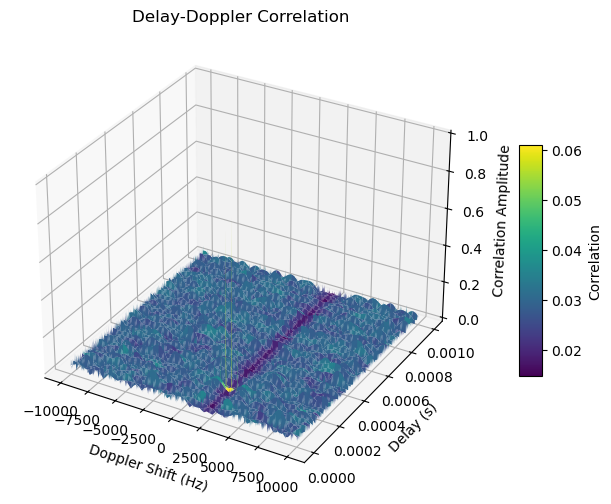

Delay:  507 samples
Delay:  165.20039100684264 microseconds
Doppler:  2250 Hz
Pseudorange: 49560.117302052786 m


In [42]:
fs = 3.069e6
Ts = 1/fs
dynamic_signal = channel_model.dynamic(bpsk_upsampled)

doppler_bins = np.arange(-10000, 10000 + 1, 250)  # 81 bins
delay_bins = np.arange(0, N) 
delay_axis = delay_bins * Ts 
t = np.arange(N) / fs

matrix = np.zeros((len(delay_bins), len(doppler_bins))) # initialize the 2D matrix

for j, fd in enumerate(doppler_bins):
    doppler_shifted_signal = np.exp(-1j * 2 * np.pi * fd * t) * dynamic_signal
    full_corr = np.array(cyclic_autocorrelate(bpsk_upsampled, doppler_shifted_signal,N))
    matrix[:, j] = np.real(full_corr[delay_bins])

X, Y = np.meshgrid(doppler_bins, delay_axis)  
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, matrix,cmap=cm.viridis,linewidth=0,antialiased=True)

ax.set_xlabel('Doppler Shift (Hz)')
ax.set_ylabel('Delay (s)')
ax.set_zlabel('Correlation Amplitude')
ax.set_title('Delay-Doppler Correlation')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Correlation')
plt.show()

# Calculate pseudorange and doppler shift of dynamic channel
# find the delay and doppler index of the peak in the matrix
max_delay_index, max_doppler_index = np.unravel_index(np.argmax(matrix), matrix.shape)

# find values 
max_delay = delay_bins[max_delay_index]
doppler_in_hz = doppler_bins[max_doppler_index]

tau_hat = max_delay / fs # calculate TOF delay
rho_hat = tau_hat * c # calculate pseudorange
tau_hat = tau_hat*(10**6) 

# Estimate doppler shift and pseudorange of channel
print("Delay: ", max_delay, "samples")
print("Delay: ", tau_hat, "microseconds")
print("Doppler: ", doppler_in_hz, "Hz")
print("Pseudorange:", rho_hat, "m")

# Part D: Find Unambiguous Range


In [43]:
rho1 = 49560 # in m
rho2 = 468000 # in m
possible_rho = 51000
epsilon = 10000.0
possible_arr = []
while possible_rho < 25800000:
    if abs((possible_rho % 510000) - (rho2 % 510000)) < epsilon:
        if possible_rho > 20200000:
            possible_arr.append(possible_rho)
    possible_rho += 300000
print("Unambiguous range:", possible_arr[0], "m")


Unambiguous range: 24951000 m
